---
# **Importing Libraries and Setting Up Environment**

- Suppress warnings to keep the output clean.
- Import essential Python libraries for:
  - **Data handling**: `pandas`, `numpy`
  - **Visualization**: `matplotlib`, `seaborn`
  - **Text preprocessing**: `re`, `html`, `string`, `emoji`, `BeautifulSoup`, `nltk`, `TextBlob`
  - **Feature extraction and encoding**: `TfidfVectorizer`, `LabelEncoder`, `label_binarize`
  - **Machine Learning models**: Logistic Regression, Naive Bayes, Decision Tree, Random Forest, Linear SVM
  - **Deep Learning models**: Keras layers (LSTM, SimpleRNN, Dense, Embedding, Dropout)
  - **Evaluation metrics**: accuracy, classification report, confusion matrix, ROC curve
  - **Model training utilities**: `train_test_split`
- Download necessary NLTK resources (`punkt`, `stopwords`, `wordnet`, `omw-1.4`) for text preprocessing.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import string
import emoji
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from keras.preprocessing import sequence
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2025-09-29 22:04:36.380494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759183476.431225     238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759183476.445654     238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin c

---
# **Load Data**

- Load the training and validation CSV files using `pandas.read_csv`.
- Assign column names: `ID`, `Topic`, `Sentiment`, and `Text`.
- Training data will be used to **train the models**, and validation data will be used to **evaluate model performance**.
- Display the first few rows of the training set to inspect the data.


In [2]:
train = pd.read_csv(
    "/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

valid = pd.read_csv(
    "/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

train.head()

,ID,Topic,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Topic      1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [5]:
train.describe()

,ID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [6]:
valid.describe()

,ID
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


---
# **Pra‑Prosesing**
Before sentiment classification, tweets are cleaned to make them consistent and suitable for modeling. Steps:

1. **HTML Decoding**  
   - Convert HTML entities like `&amp;` to `&`.

2. **Lowercasing**  
   - All text converted to lowercase for consistency.

3. **Remove URLs, Mentions, and Hashtags**  
   - Remove links (`http://...`, `www...`), mentions (`@user`), and hashtags (`#`) while keeping the words.

4. **Remove Non-Alphanumeric Characters**  
   - Remove punctuation, symbols, and special characters.

5. **Tokenization, Stopword Removal, Lemmatization**  
   - Split text into words, remove common stopwords (e.g., `the`, `is`, `and`), and convert words to their base form (e.g., `running` → `run`).


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train['clean_text'] = train['Text'].apply(clean_text)
valid['clean_text'] = valid['Text'].apply(clean_text)

print(train[['Text', 'clean_text']].head(10))

                                                Text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   
5  im getting into borderlands and i can murder y...   
6  So I spent a few hours making something for fu...   
7  So I spent a couple of hours doing something f...   
8  So I spent a few hours doing something for fun...   
9  So I spent a few hours making something for fu...   

                                          clean_text  
0                       im getting borderland murder  
1                                 coming border kill  
2                         im getting borderland kill  
3                        im coming borderland murder  
4                       im getting borderland murder  
5                       im getting borderland murder 

---
# **Label Encoding**

1. **Initialize LabelEncoder** from scikit-learn.
2. **Fit the encoder** on the combined train and validation labels to ensure all classes are recognized.
3. **Transform textual sentiment labels** into numerical labels for model training.
4. **Check class distribution** in training and validation sets to detect any imbalance.


In [8]:
le = LabelEncoder()
le.fit(pd.concat([train['Sentiment'], valid['Sentiment']], axis=0))

train['label_enc'] = le.transform(train['Sentiment'])
valid['label_enc'] = le.transform(valid['Sentiment'])

print("Label mapping (index -> label):", dict(enumerate(le.classes_)))
print("\nTrain class counts:\n", train['Sentiment'].value_counts())
print("\nValid class counts:\n", valid['Sentiment'].value_counts())

Label mapping (index -> label): {0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

Train class counts:
 Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Valid class counts:
 Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


---
# **Feature Extraction: TF-IDF**

1. **Initialize TF-IDF Vectorizer**:
   - Max 10,000 features (`max_features=10000`)
   - Use unigrams and bigrams (`ngram_range=(1,2)`)
   - Remove English stopwords

2. **Transform training and validation texts**:
   - `fit_transform` on training data → learn vocabulary + generate TF-IDF matrix
   - `transform` on validation data → use training vocabulary only

3. **Prepare target labels** (`y_train`, `y_valid`) from encoded sentiment labels.

4. **Check matrix shapes**:
   - `X_train.shape` and `X_valid.shape`


In [9]:
tfv = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train = tfv.fit_transform(train['clean_text'])
X_valid = tfv.transform(valid['clean_text'])
y_train = train['label_enc']
y_valid = valid['label_enc']

print("\nTF-IDF matrix shapes, X_train, X_valid:", X_train.shape, X_valid.shape)


TF-IDF matrix shapes, X_train, X_valid: (74682, 10000) (1000, 10000)


---
# **Model Training and Evaluation**

In this section, we compare the performance of several classical machine learning models on the sentiment analysis dataset.

1. **Define multiple classical ML models**:
   - Logistic Regression, Multinomial Naive Bayes, Decision Tree, Random Forest, Linear SVM

2. **Train and evaluate each model**:
   - Fit the model on training TF-IDF features
   - Predict on validation set
   - Calculate accuracy score
   - Store results in a dictionary

3. **Convert results to DataFrame** for easy comparison and visualization:
   - Columns: `Model` and `Accuracy`


In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

res_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

Logistic Regression Accuracy: 0.8650
Naive Bayes Accuracy: 0.7450
Decision Tree Accuracy: 0.8860
Random Forest Accuracy: 0.9460
Linear SVM Accuracy: 0.9040


---
# **Visualizing Model Performance**

The following code generates a **bar chart** to compare the accuracy of different machine learning models on the validation set:

- X-axis: model names
- Y-axis: accuracy scores
- Uses `seaborn` barplot for clear visualization
- Rotates x-axis labels for readability
- Helps quickly identify the best-performing model


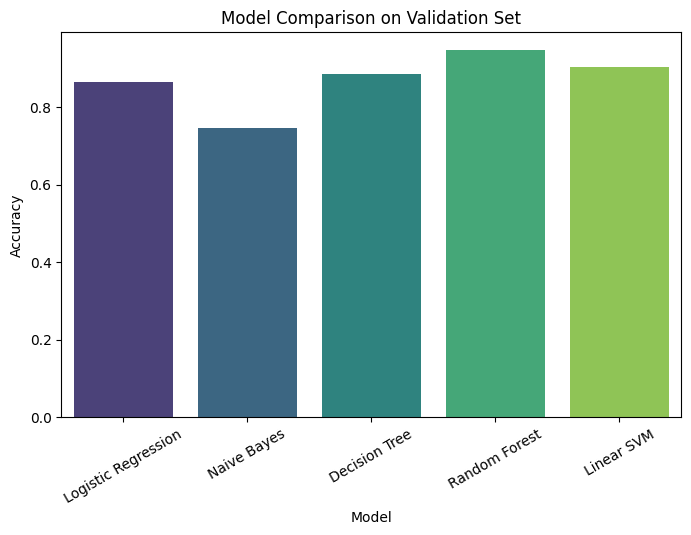

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=res_df, palette="viridis")
plt.title("Model Comparison on Validation Set")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

---
# **Detailed Model Evaluation**

This section performs an in-depth evaluation of each machine learning model on the validation set:

1. **Convert labels to one-hot encoding** for ROC curve computation.
2. **Train and predict** each model.
3. **Calculate accuracy** and display the classification report (precision, recall, F1-score) for each class.
4. **Display the confusion matrix** to visualize prediction errors per class.
5. **Plot ROC curves** for models that support probability predictions to assess class-wise performance.



Logistic Regression Accuracy: 0.8650
              precision    recall  f1-score   support

  Irrelevant       0.87      0.79      0.83       172
    Negative       0.83      0.92      0.87       266
     Neutral       0.93      0.85      0.89       285
    Positive       0.85      0.87      0.86       277

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

Confusion Matrix for Logistic Regression:


<Figure size 1200x800 with 0 Axes>

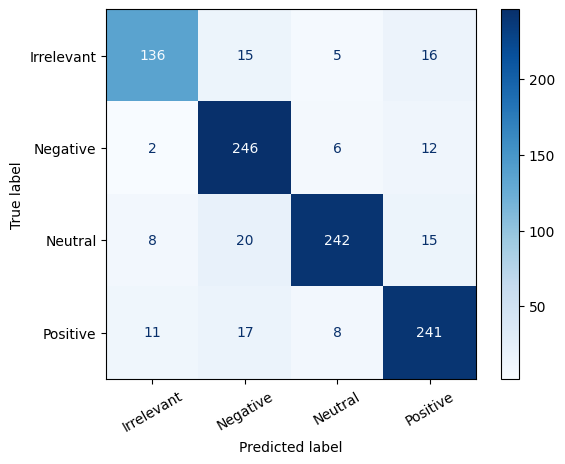

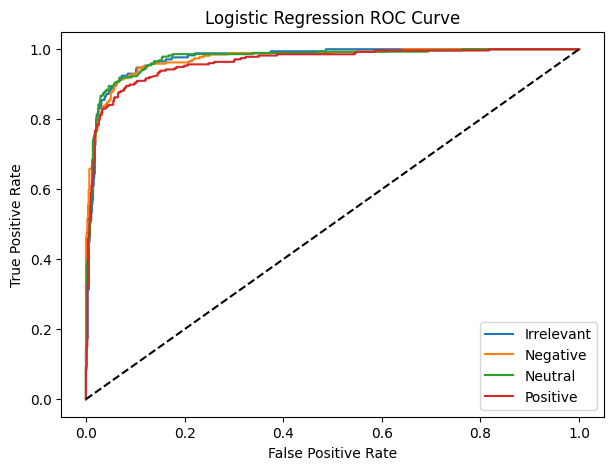


Naive Bayes Accuracy: 0.7450
              precision    recall  f1-score   support

  Irrelevant       0.84      0.58      0.69       172
    Negative       0.67      0.84      0.75       266
     Neutral       0.81      0.65      0.72       285
    Positive       0.74      0.85      0.79       277

    accuracy                           0.74      1000
   macro avg       0.77      0.73      0.74      1000
weighted avg       0.76      0.74      0.74      1000

Confusion Matrix for Naive Bayes:


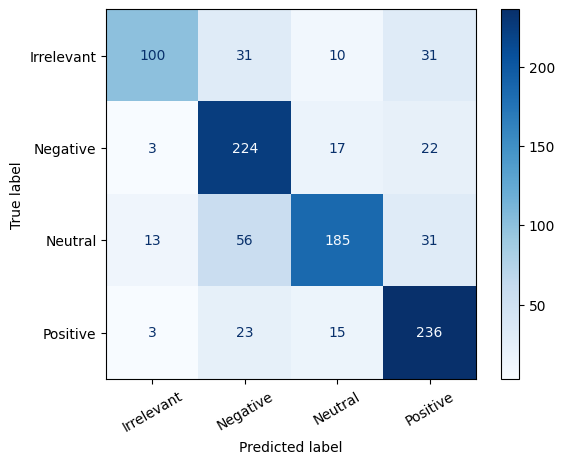

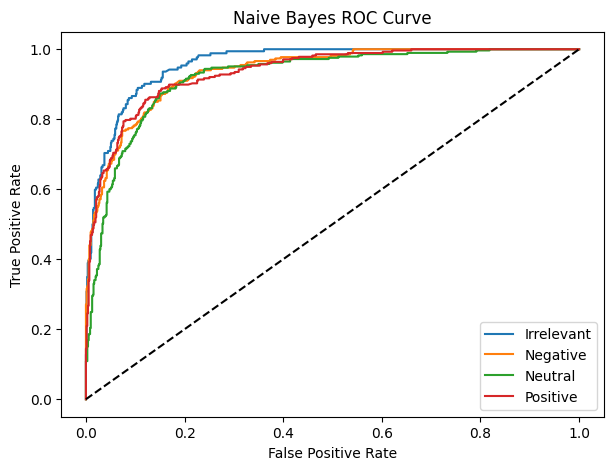


Decision Tree Accuracy: 0.8860
              precision    recall  f1-score   support

  Irrelevant       0.88      0.85      0.86       172
    Negative       0.88      0.94      0.91       266
     Neutral       0.90      0.87      0.88       285
    Positive       0.89      0.87      0.88       277

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.89      1000

Confusion Matrix for Decision Tree:


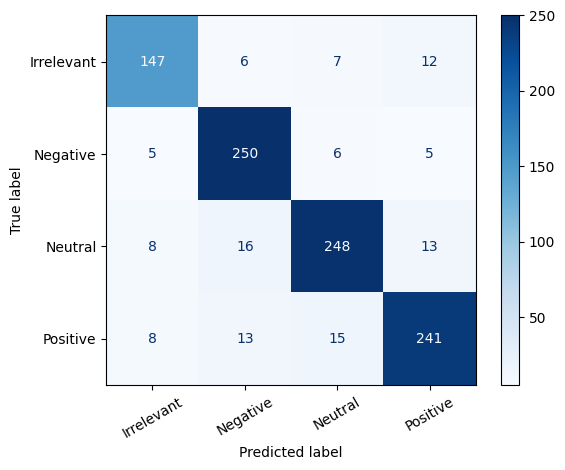

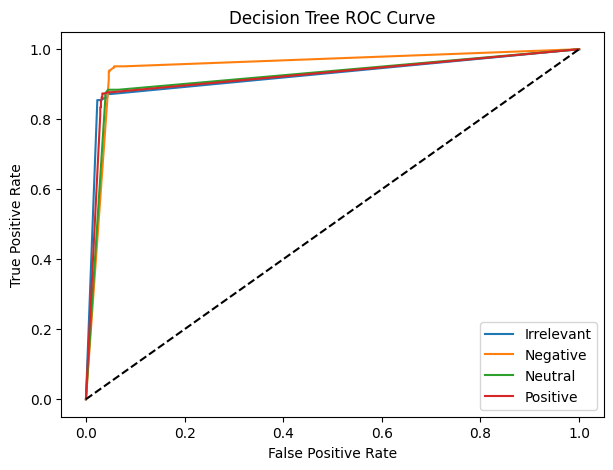


Random Forest Accuracy: 0.9460
              precision    recall  f1-score   support

  Irrelevant       0.97      0.92      0.94       172
    Negative       0.92      0.96      0.94       266
     Neutral       0.97      0.94      0.95       285
    Positive       0.93      0.96      0.94       277

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix for Random Forest:


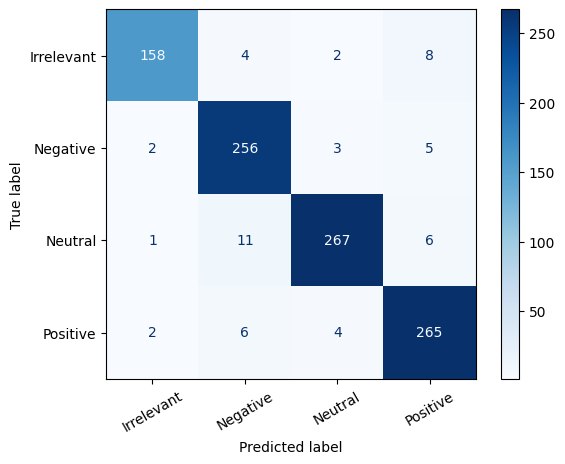

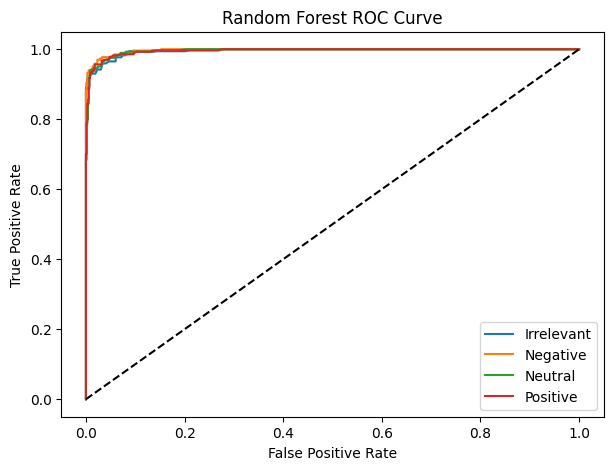


Linear SVM Accuracy: 0.9040
              precision    recall  f1-score   support

  Irrelevant       0.90      0.88      0.89       172
    Negative       0.88      0.95      0.91       266
     Neutral       0.94      0.91      0.92       285
    Positive       0.89      0.87      0.88       277

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Confusion Matrix for Linear SVM:


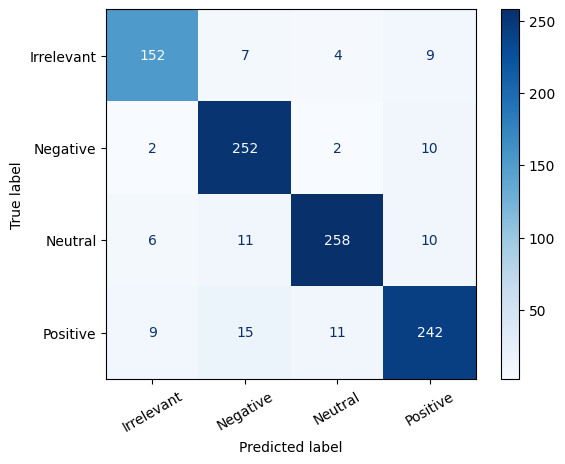

In [12]:
y_valid_bin = label_binarize(y_valid, classes=range(len(le.classes_)))
n_classes = y_valid_bin.shape[1]

plt.figure(figsize=(12, 8))

for idx, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    acc = accuracy_score(y_valid, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    
    print(classification_report(y_valid, y_pred, target_names=le.classes_))
    
    print(f"Confusion Matrix for {name}:")
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_valid, y_valid,
        display_labels=le.classes_,
        cmap='Blues',
        xticks_rotation=30
    )
    
    y_score = model.predict_proba(X_valid) if hasattr(model, "predict_proba") else None
    if y_score is not None:
        plt.figure(figsize=(7,5))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{le.classes_[i]}")
        plt.plot([0,1], [0,1], 'k--')
        plt.title(f"{name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

---
# **Final Model Training and Saving**

1. **Select the final model** based on previous evaluation (Random Forest).
2. **Combine training and validation datasets** to use all available data for final training.
3. **Fit the final model** on the full dataset with TF-IDF features.
4. **Save the trained model and preprocessing objects**:
   - Random Forest model (`random_forest.pkl`)
   - TF-IDF Vectorizer (`tfidf_vectorizer.pkl`)
   - Label Encoder (`label_encoder.pkl`)
5. This ensures the model and preprocessing steps can be reused for future predictions without retraining.


In [13]:
print("Final Model: Random Forest")

X_full = tfv.fit_transform(pd.concat([train['clean_text'], valid['clean_text']], axis=0))
y_full = pd.concat([train['label_enc'], valid['label_enc']], axis=0)

final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_full, y_full)

import joblib
joblib.dump(final_model, "random_forest.pkl")
joblib.dump(tfv, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

print("\nFinal model and preprocessing objects saved successfully")

Final Model: Random Forest

Final model and preprocessing objects saved successfully
